In [1]:
import argparse
import os
import sys
import pickle
import time
import subprocess
import shutil
sys.path.append(os.getcwd())

from khrylib.utils import *
from khrylib.rl.utils.visualizer import Visualizer
from khrylib.rl.core.policy_gaussian import PolicyGaussian
from khrylib.rl.core.critic import Value
from khrylib.models.mlp import MLP
from motion_imitation.envs.humanoid_im import HumanoidEnv, HumanoidEnvFreezeKnee
from motion_imitation.utils.config import Config
import matplotlib.pyplot as plt
import glfw




In [2]:
cfg = Config('0202', False, create_dirs=False)
cfg_f = Config('0202_freeze', False, create_dirs=False)
cfg.env_start_first = True
cfg_f.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)
env.seed(cfg.seed)


body_qposaddr = get_body_qposaddr(env.model)
body_qposaddr_list_start_index = [idxs[0] for idxs in list(body_qposaddr.values())]
knee_idx = body_qposaddr_list_start_index[2]
def plot_qpos(qpos, body_qposaddr_list_start_index):
    fig, axs = plt.subplots(nrows=qpos.shape[1]//4+1, ncols=4, figsize=(10, 12))
    for i in range(qpos.shape[1]//4+1):
        for j in range(4):
            idx = i*4 + j
            if idx >= qpos.shape[1]:
                break
            gt = qpos[:, idx]
            axs[i, j].plot(gt, 'r', label='gt')
            axs[i, j].set_ylim([-np.pi, np.pi])
            if idx in body_qposaddr_list_start_index:
                body_name = [name for name, addr in body_qposaddr.items() if addr[0] == idx][0]
                axs[i, j].set_title(f"idx = {idx}, {body_name}", fontsize=12)
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_qpos(qpos, body_qposaddr_list_start_index )



env_f = HumanoidEnvFreezeKnee(cfg_f, cfg)
env_f.seed(cfg_f.seed)

actuators = env.model.actuator_names
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actuators_f = env_f.model.actuator_names
state_dim_f = env_f.observation_space.shape[0]
action_dim_f = env_f.action_space.shape[0]

"""load learner policy"""
policy_net = PolicyGaussian(MLP(state_dim, cfg.policy_hsize, cfg.policy_htype), action_dim, log_std=cfg.log_std, fix_std=cfg.fix_std)
value_net = Value(MLP(state_dim, cfg.value_hsize, cfg.value_htype))
cp_path = '%s/iter_%04d.p' % (cfg.model_dir, 800)
logger.info('loading model from checkpoint: %s' % cp_path)
model_cp = pickle.load(open(cp_path, "rb"))
policy_net.load_state_dict(model_cp['policy_dict'])
value_net.load_state_dict(model_cp['value_dict'])
running_state = model_cp['running_state']


dim of qpos, qvel = ((39,), (38,))


loading model from checkpoint: results/motion_im/0202/models/iter_0800.p


In [3]:
class MyVisulizerFK(Visualizer):

    def __init__(self, vis_file):
        super().__init__(vis_file)
        ngeom = len(env.model.geom_rgba) - 1
        self.env_vis.model.geom_rgba[ngeom + 21: ngeom * 2 + 21] = np.array([0.7, 0.0, 0.0, 1])
        self.env_vis.viewer.cam.lookat[2] = 1.0
        self.env_vis.viewer.cam.azimuth = 45
        self.env_vis.viewer.cam.elevation = -8.0
        self.env_vis.viewer.cam.distance = 5.0
        self.T = 12

    def data_generator(self):
        poses = {'pred': [], 'gt': []}
        state = env_f.reset()
        # print(env_f.init_qpos[1], env.expert['qpos'][0,1])
        assert env_f.init_qpos_f[1] == env.expert['qpos'][0,1], "init_qpos[1] != expert_qpos[0,1]"
        assert np.allclose(env_f.init_qpos_f, env_f.data.qpos), "init_qpos[1] != qpos[0,1]"

        # state_f_qpos, state_f_qvel = state_f[:env_f.data.qpos.shape[0]], state_f[env_f.data.qpos.shape[0]:]
        # state_old = np.concatenate([state_f_qpos[:knee_idx ], np.zeros(4),state_f_qpos[knee_idx:], state_f_qvel[:knee_idx ], np.zeros(4), state_f_qvel[knee_idx:], 0.*np.ones(1)])
        if running_state is not None:
            state = running_state(state, update=False)
        for t in range(75): 
            
            epos = env.get_expert_attr('qpos', env.get_expert_index(t)).copy()
            # print(epos.shape)
            if env.expert['meta']['cyclic']:
                init_pos = env.expert['init_pos']
                cycle_h = env.expert['cycle_relheading'] # relative heading quaternion
                cycle_pos = env.expert['cycle_pos']
                epos[:3] = quat_mul_vec(cycle_h, epos[:3] - init_pos) + cycle_pos 
                epos[3:7] = quaternion_multiply(cycle_h, epos[3:7])
            poses['gt'].append(epos) 
            qpos = env_f.data.qpos.copy()
            qpos = np.concatenate([qpos[:knee_idx ], np.zeros(4),qpos[knee_idx:]])
            poses['pred'].append(qpos)
            
            state_var = tensor(state, dtype=dtype).unsqueeze(0)
            action = policy_net.select_action(state_var, mean_action=True)[0].cpu().numpy()
            # print(t, state.shape, action.shape)
            next_state, reward, done, fail = env_f.step(action)
            # print(np.std(next_state_f))
            if running_state is not None:
                next_state = running_state(next_state, update=False)
            if done:
                # print(f"fail: {info['fail']}")
                break
            state = next_state
            # print("np.std(state) vs ",np.std(state), np.std(epos))

        poses['gt'] = np.vstack(poses['gt'])
        poses['pred'] = np.vstack(poses['pred'])
        plot_pose = True
        if plot_pose:
            # import matplotlib.pyplot as plt
            fig, axs = plt.subplots(nrows=poses['gt'].shape[1]//4+1, ncols=4, figsize=(10, 12))
            for i in range(poses['gt'].shape[1]//4+1):
                for j in range(4):
                    if i*4 + j < poses['gt'].shape[1]:
                        gt = poses['gt'][:, i*4 + j]
                        pred = poses['pred'][:, i*4 + j]
                        mse = np.mean((gt - pred) ** 2)
                        axs[i, j].plot(gt, 'r', label='gt')
                        axs[i, j].plot(pred, 'b', label='pred')
                        axs[i, j].set_ylim([-np.pi, np.pi])
                        axs[i, j].set_title(f'{i*4 + j} MSE: {mse:.4f}')
                    if i == 0 and j == 0:
                        axs[i, j].legend()
            plt.tight_layout()
            plt.show()
        self.num_fr = poses['pred'].shape[0]
        yield poses
            

    def update_pose(self):
        self.env_vis.data.qpos[:env.model.nq] = self.data['pred'][self.fr]
        self.env_vis.data.qpos[env.model.nq:] = self.data['gt'][self.fr] 
        self.env_vis.data.qpos[env.model.nq] += 1.0 # time update
        # if args.record_expert:
        # self.env_vis.data.qpos[:env.model.nq] = self.data['gt'][self.fr]
        if True: #args.hide_expert:
            self.env_vis.data.qpos[env.model.nq + 2] = 100.0
        # if args.focus:
        #     self.env_vis.viewer.cam.lookat[:2] = self.env_vis.data.qpos[:2]
        self.env_vis.sim_forward()

    def record_video(self):
        frame_dir = f'out/videos/freeze_knee/frames'
        if os.path.exists(frame_dir):
            shutil.rmtree(frame_dir)
        os.makedirs(frame_dir, exist_ok=True)
        for fr in range(self.num_fr):
            # print("hi")
            self.fr = fr
            self.update_pose()
            for _ in range(200): 
                self.render()
            if True: # not args.preview:
                t0 = time.time()
                # save_screen_shots(self.env_vis.viewer.window,f'{frame_dir}/%04d.png' % fr,  autogui = True)
                
                width, height = glfw.get_window_size(self.env_vis.viewer.window)
                data = self.env_vis._get_viewer("human").read_pixels(width, height, depth=False)
                save_image_hwc(data[::-1, :, [0,1,2]],  f'{frame_dir}/%04d.png' % fr)
                print('%d/%d, %.3f' % (fr, self.num_fr, time.time() - t0))

        if True: #not args.preview:
            out_name = f'out/videos/freeze_knee/0202_800.mp4'
            cmd = ['ffmpeg', '-y', '-r', '30', '-f', 'image2', '-start_number', '0',
                '-i', f'{frame_dir}/%04d.png', '-vcodec', 'libx264', '-crf', '5', '-pix_fmt', 'yuv420p', out_name]
            subprocess.call(cmd)

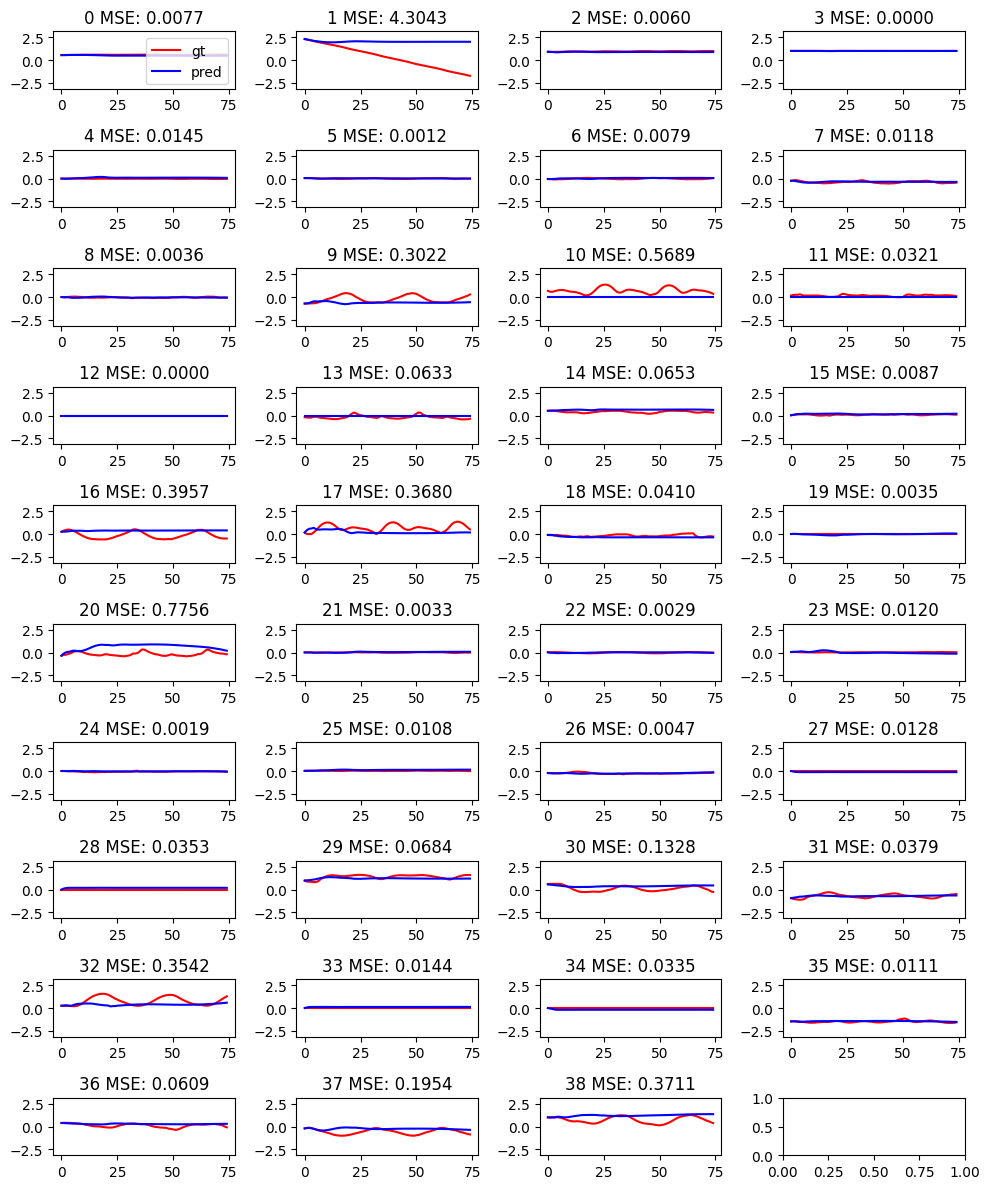

Creating window glfw


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


0/75, 0.301
1/75, 0.276
2/75, 0.278
3/75, 0.281
4/75, 0.276
5/75, 0.292
6/75, 0.306
7/75, 0.280
8/75, 0.274
9/75, 0.281
10/75, 0.287
11/75, 0.258
12/75, 0.281
13/75, 0.254
14/75, 0.263
15/75, 0.258
16/75, 0.275
17/75, 0.274
18/75, 0.279
19/75, 0.274
20/75, 0.289
21/75, 0.292
22/75, 0.291
23/75, 0.270
24/75, 0.282
25/75, 0.285
26/75, 0.280
27/75, 0.268
28/75, 0.280
29/75, 0.293
30/75, 0.287
31/75, 0.281
32/75, 0.295
33/75, 0.284
34/75, 0.313
35/75, 0.295
36/75, 0.253
37/75, 0.298
38/75, 0.301
39/75, 0.255
40/75, 0.278
41/75, 0.280
42/75, 0.256
43/75, 0.295
44/75, 0.248
45/75, 0.281
46/75, 0.276
47/75, 0.287
48/75, 0.272
49/75, 0.257
50/75, 0.275
51/75, 0.292
52/75, 0.275
53/75, 0.286
54/75, 0.283
55/75, 0.256
56/75, 0.284
57/75, 0.248
58/75, 0.263
59/75, 0.280
60/75, 0.264
61/75, 0.261
62/75, 0.273
63/75, 0.262
64/75, 0.271
65/75, 0.261
66/75, 0.258
67/75, 0.235
68/75, 0.266
69/75, 0.274
70/75, 0.268
71/75, 0.279
72/75, 0.242
73/75, 0.284
74/75, 0.236


ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

In [4]:

vis = MyVisulizerFK(f'mocap_v2_vis.xml')
# vis.num_fr

vis.record_video()


In [5]:
out_name = f'out/videos/freeze_knee/0202_800.mp4'
frame_dir = f'out/videos/freeze_knee/frames'
cmd = ['ffmpeg', '-y', '-r', '30', '-f', 'image2', '-start_number', '0',
    '-i', f'{frame_dir}/%04d.png', '-vcodec', 'libx264', '-crf', '5', '-pix_fmt', 'yuv420p', out_name]
subprocess.call(cmd)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

0